In [1]:
from twitterscraper import query_tweets
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import seaborn as sns
import hypertools as hyp
import numpy as np
from textblob import TextBlob as tb
import nltk
import datetime as dt
nltk.download('brown')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#scrape twitter for most recent tweets on the wnba finals...this will take a while
n_tweets = 500
tweets = []
for tweet in query_tweets("womens basketball", n_tweets)[:n_tweets]:
    tweets.append(tweet)

In [3]:
#get the tweet text
tweet_text = list(map(lambda x: x.text, tweets))

In [4]:
#get twitter user name
tweets[0].user

'hsajseoss1988'

In [5]:
#convert the data to a useable format
n_features = 300
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweet_text)
tf_feature_names = tf_vectorizer.get_feature_names()

In [6]:
#fit a topic model to the tweets
n_topics = 6
lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
tweet_topics = lda.fit(tf)

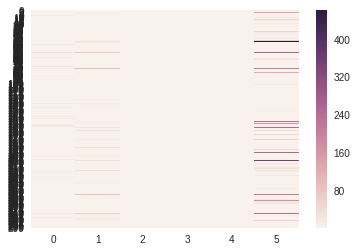

In [7]:
#topic vectors for each tweet
sns.heatmap(tweet_topics.components_.T)

In [8]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic ' + str(topic_idx) + ': ', end='')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
display_topics(lda, tf_feature_names, 5)

Topic 0: basketball clippers nba new womens
Topic 1: com twitter basketball womens retro
Topic 2: good luck wnba womensbasketball home
Topic 3: shoes basketball nike womens twitter
Topic 4: womensbasketball love womeninsports women rise
Topic 5: air shoes basketball running nike


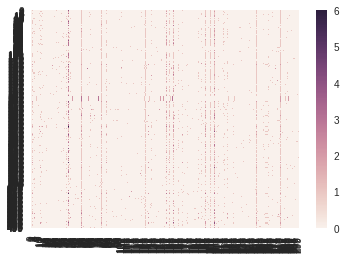

In [10]:
sns.heatmap(tf.todense())

In [11]:
blob = tb(tweet_text[0])

In [12]:
def tweet_sentiment(tweet):
    b = tb(tweet)
    return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))

In [13]:
sentiments = list(map(tweet_sentiment, tweet_text))

In [14]:
#happiest tweet
tweet_text[np.where(sentiments == np.max(sentiments))[0][0]]

'Happy Birthday to Alex! From kstatewbb!! One of the best Managers in college Basketball!  We love you Alex #CPApic.twitter.com/j7NH5XAVvy'

In [15]:
#saddest tweet
tweet_text[np.where(sentiments == np.min(sentiments))[0][0]]

'Hey at least we got osu baseball and womens basketball too look forward too, cause the JV football team is terrible!!'

In [16]:
#make a hypertools plot of the tweets, colored by sentiment
hyp.plot(tweet_topics.components_.T, '.', group=sentiments, palette='RdBu_r', model='SpectralEmbedding');

IndexError: index 300 is out of bounds for axis 0 with size 300

In [19]:
# function for scraping twitter for one or more keywords and returning a dictionary with:
# - tweets: the tweet text (list of length n_tweets)
# - topicvecs: the tweet topic vectors (numpy array with n_tweets rows and n_topics columns)
# - topwords: the top n words from each topic (list of length n_topics, where each element is a list of n_words)
# - sentiments: the sentiment valence of each tweet (numpy array of length n_tweets)

def twitter_magic(keywords, n_tweets=500, n_topics=10, n_words=5, model=None):
    #if keywords is a list, combine all keywords into a single string, where each word is separated by " OR "
    if type(keywords) == list:
        keywords = ' OR '.join(keywords)
    
    #get the tweets
    tweets = []
    for tweet in query_tweets(keywords, n_tweets)[:n_tweets]:
        tweets.append(tweet)
    
    #get the tweet text
    tweet_text = list(map(lambda x: x.text, tweets))
    
    #get the twitter users
    tweet_users = list(map(lambda x: x.user, tweets))
    
    #fit a topic model to the tweet text    
    n_features = 1000
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(tweet_text)    
    vocab = tf_vectorizer.get_feature_names()
    
    if model == None:
        lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
    else:
        lda = model            
    tweet_topics = lda.fit(tf)
    
    def get_top_words(model, vocab, n_words):
        top_words = []
        for topic_idx, topic in enumerate(model.components_):       
            next = topic.argsort()[:-n_words - 1:-1]
            top_words.append(list(map(lambda x: vocab[x], next)))
        return top_words
    
    def tweet_sentiment(tweet):
        b = tb(tweet)
        return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))
    
    return{'tweets': tweet_text,
           'users': tweet_users,
           'topicvecs': lda.components_.T,
           'topwords': get_top_words(lda, vocab, n_words),
           'sentiments': np.array(list(map(tweet_sentiment, tweet_text))),
           'model': lda}

In [47]:
n = 100 #number of tweets to download for each team

dartmouth = twitter_magic(['womens basketball AND dartmouth', 'ivy AND dartmouth'], n_tweets=n)

#now fit clinton tweets using the topic model from trump_election_tweets (otherwise the topic vectors will be different)
harvard = twitter_magic(['womens basketball AND harvard', 'ivy AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit sanders tweets (using the same topic model)
yale = twitter_magic(['womens basketball AND yale', 'ivy AND yale'], n_tweets=n, model=dartmouth['model'])


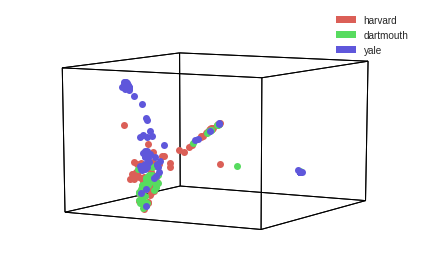

In [48]:
#plot the trump and clinton tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], yale['topicvecs']],
         'o', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'yale']);

In [51]:
n = 300 #number of tweets to download for each team

dartmouth = twitter_magic(['womens basketball AND dartmouth', 'ivy AND dartmouth'], n_tweets=n)

#now fit clinton tweets using the topic model from trump_election_tweets (otherwise the topic vectors will be different)
harvard = twitter_magic(['womens basketball AND harvard', 'ivy AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit sanders tweets (using the same topic model)
princeton = twitter_magic(['womens basketball AND princeton', 'ivy AND princeton'], n_tweets=n, model=dartmouth['model'])


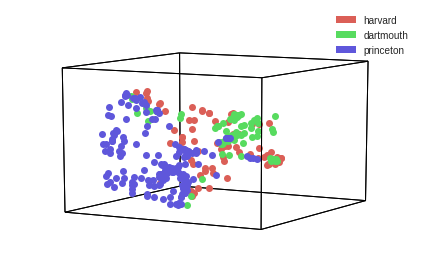

In [52]:
#plot the trump and clinton tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], princeton['topicvecs']],
         'o', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'princeton']);

In [45]:
n = 100 #number of tweets to download for each team

dartmouth = twitter_magic(['football AND dartmouth'], n_tweets=n)

#now fit havard football tweets using the topic model from dartmouth (otherwise the topic vectors will be different)
harvard = twitter_magic(['football AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit yale tweets (using the same topic model)
yale = twitter_magic(['football AND yale'], n_tweets=n, model=dartmouth['model'])


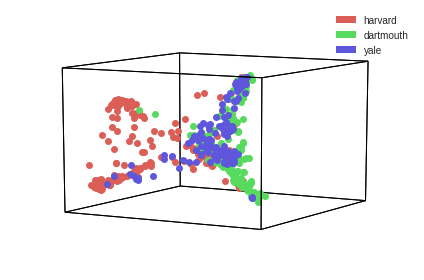

In [46]:
#plot the dartmouth, harvard, and yale football tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], yale['topicvecs']],
         'o', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'yale']);

In [68]:
n = 600 #number of tweets to download for each team

dartmouth = twitter_magic(['football AND dartmouth'], n_tweets=n)

#now fit havard football tweets using the topic model from dartmouth (otherwise the topic vectors will be different)
harvard = twitter_magic(['football AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit yale tweets (using the same topic model)
yale = twitter_magic(['football AND yale'], n_tweets=n, model=dartmouth['model'])


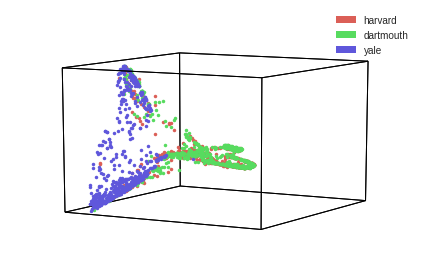

In [69]:
#plot the dartmouth, harvard, and yale football tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], yale['topicvecs']],
         '.', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'yale']);

In [70]:
n = 500 #number of tweets to download for each team

dartmouth = twitter_magic(['football AND dartmouth'], n_tweets=n)

#now fit havard football tweets using the topic model from dartmouth (otherwise the topic vectors will be different)
harvard = twitter_magic(['football AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit yale tweets (using the same topic model)
yale = twitter_magic(['football AND yale'], n_tweets=n, model=dartmouth['model'])


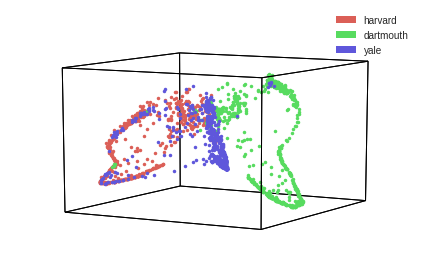

In [71]:
#plot the dartmouth, harvard, and yale football tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], yale['topicvecs']],
         '.', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'yale']);

In [72]:
n = 400 #number of tweets to download for each team

dartmouth = twitter_magic(['football AND dartmouth'], n_tweets=n)

#now fit havard football tweets using the topic model from dartmouth (otherwise the topic vectors will be different)
harvard = twitter_magic(['football AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit yale tweets (using the same topic model)
yale = twitter_magic(['football AND yale'], n_tweets=n, model=dartmouth['model'])


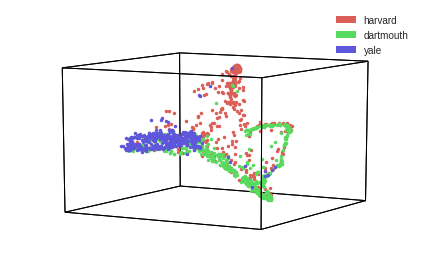

In [73]:
#plot the dartmouth, harvard, and yale football tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], yale['topicvecs']],
         '.', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'yale']);

In [74]:
n = 300 #number of tweets to download for each team

dartmouth = twitter_magic(['football AND dartmouth'], n_tweets=n)

#now fit havard football tweets using the topic model from dartmouth (otherwise the topic vectors will be different)
harvard = twitter_magic(['football AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit yale tweets (using the same topic model)
yale = twitter_magic(['football AND yale'], n_tweets=n, model=dartmouth['model'])


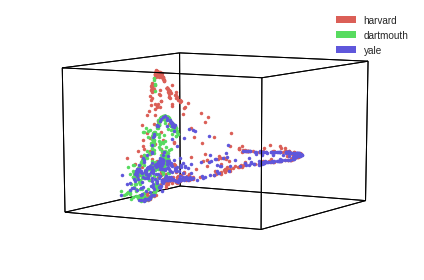

In [75]:
#plot the dartmouth, harvard, and yale football tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], yale['topicvecs']],
         '.', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'yale']);

In [76]:
n = 200 #number of tweets to download for each team

dartmouth = twitter_magic(['football AND dartmouth'], n_tweets=n)

#now fit havard football tweets using the topic model from dartmouth (otherwise the topic vectors will be different)
harvard = twitter_magic(['football AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit yale tweets (using the same topic model)
yale = twitter_magic(['football AND yale'], n_tweets=n, model=dartmouth['model'])


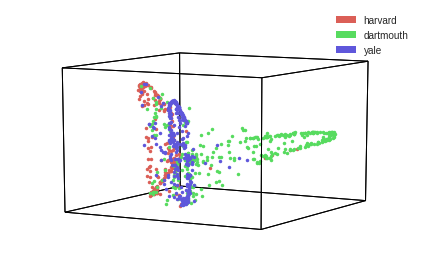

In [77]:
#plot the dartmouth, harvard, and yale football tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], yale['topicvecs']],
         '.', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'yale']);

In [78]:
n = 100 #number of tweets to download for each team

dartmouth = twitter_magic(['football AND dartmouth'], n_tweets=n)

#now fit havard football tweets using the topic model from dartmouth (otherwise the topic vectors will be different)
harvard = twitter_magic(['football AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit yale tweets (using the same topic model)
yale = twitter_magic(['football AND yale'], n_tweets=n, model=dartmouth['model'])

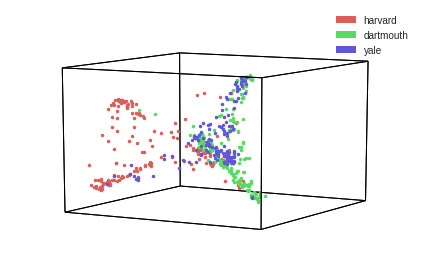

In [79]:
#plot the dartmouth, harvard, and yale football tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], yale['topicvecs']],
         '.', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'yale']);

In [80]:
n = 50 #number of tweets to download for each team

dartmouth = twitter_magic(['football AND dartmouth'], n_tweets=n)

#now fit havard football tweets using the topic model from dartmouth (otherwise the topic vectors will be different)
harvard = twitter_magic(['football AND harvard'], n_tweets=n, model=dartmouth['model'])

#now fit yale tweets (using the same topic model)
yale = twitter_magic(['football AND yale'], n_tweets=n, model=dartmouth['model'])

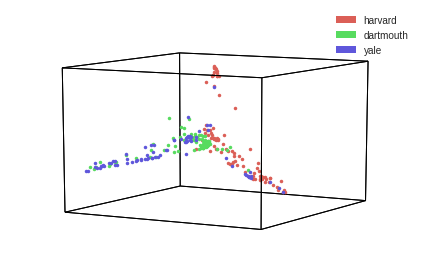

In [81]:
#plot the dartmouth, harvard, and yale football tweets
hyp.plot([harvard['topicvecs'], dartmouth['topicvecs'], yale['topicvecs']],
         '.', model='SpectralEmbedding', legend=['harvard', 'dartmouth', 'yale']);